## Fuente:

[Forbes World's Billionaires List 2022](https://www.kaggle.com/datasets/prasertk/forbes-worlds-billionaires-list-2022)

Es la lista Forbes de personas más ricas del mundo de 2022.

---

In [ ]:
!pip install factor_analyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

from sklearn.decomposition import PCA

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo

from keras.models import Sequential
from keras.layers.core import Dense
from tensorflow.keras.optimizers import SGD, Adam

%pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
# Leemos y echamos un ojo

forbes = pd.read_csv("/content/forbes12.csv")

forbes.head()

,rank,personName,age,finalWorth,year,month,category,source,country,state,...,selfMade,gender,birthDate,title,philanthropyScore,residenceMsa,numberOfSiblings,bio,about,Unnamed: 22
0,1,Elon Musk,50.0,219000.0,2022,4,Automotive,"Tesla, SpaceX",United States,Texas,...,True,M,1971-06-28,CEO,1.0,NaN,NaN,Elon Musk is working to revolutionize transpor...,Musk was accepted to a graduate program at Sta...,NaN
1,2,Jeff Bezos,58.0,171000.0,2022,4,Technology,Amazon,United States,Washington,...,True,M,1964-01-12,Entrepreneur,1.0,"Seattle-Tacoma-Bellevue, WA",NaN,Jeff Bezos founded e-commerce giant Amazon in ...,"Growing up, Jeff Bezos worked summers on his g...",NaN
2,3,Bernard Arnault & family,73.0,158000.0,2022,4,Fashion & Retail,LVMH,France,NaN,...,False,M,1949-03-05,Chairman and CEO,NaN,NaN,NaN,Bernard Arnault oversees the LVMH empire of so...,"Arnault apparently wooed his wife, Helene Merc...",NaN
3,4,Bill Gates,66.0,129000.0,2022,4,Technology,Microsoft,United States,Washington,...,True,M,1955-10-28,Cofounder,4.0,"Seattle-Tacoma-Bellevue, WA",NaN,Bill Gates turned his fortune from software fi...,"When Gates was a kid, he spent so much time re...",NaN
4,5,Warren Buffett,91.0,118000.0,2022,4,Finance & Investments,Berkshire Hathaway,United States,Nebraska,...,True,M,1930-08-30,CEO,5.0,"Omaha, NE",NaN,"Known as the ""Oracle of Omaha,"" Warren Buffett...","Buffett still lives in the same Omaha, Nebrask...",NaN


In [ ]:
forbes.columns

Index(['rank', 'personName', 'age', 'finalWorth', 'year', 'month', 'category',
       'source', 'country', 'state', 'city', 'countryOfCitizenship',
       'organization', 'selfMade', 'gender', 'birthDate', 'title',
       'philanthropyScore', 'residenceMsa', 'numberOfSiblings', 'bio', 'about',
       'Unnamed: 22'],
      dtype='object')

In [ ]:
## Primero eliminamos las columnas irrelevantes
# rank - Puesto en la lista
# personName - El nombre de la persona
# year - El año (siempre 2022)
# month - El mes
# birthDate - Fecha de nacimiento
# bio - Texto biográfico
# about - Texto informativo
##
forbes.drop(columns=['rank', 'personName', 'year', 'month', 'birthDate', 'bio', 'about'], inplace=True)

### Comprobamos que el dataset sin las columnas anteriores cumple las condiciones:

#### Condición 1 - Al menos 30 filas X 10 columnas

In [ ]:
# El dataset tiene 2668 filas X 15 columnas
forbes.shape

(365, 16)

#### Condición 2 - Una columna de tipo object debe tener 2 opciones

In [ ]:
# Comprobamos los tipos de dato
forbes.dtypes

age                     float64
finalWorth              float64
category                 object
source                   object
country                  object
state                    object
city                     object
countryOfCitizenship     object
organization             object
selfMade                   bool
gender                   object
title                    object
philanthropyScore       float64
residenceMsa             object
numberOfSiblings        float64
Unnamed: 22              object
dtype: object

In [ ]:
# La columna "selfMade" (que determina si el rico en cuestión "se hizo a sí mismo") tiene 2 opciones, pero es de tipo boolean
print(forbes['selfMade'].unique())

[ True False]


In [ ]:
# La columna "gender" (género) es de tipo object, pero contiene valores nulos.
forbes['gender'].unique()

array(['M', 'F', nan], dtype=object)

In [ ]:
# Queremos eliminar las filas que contienen estos valores nulos, pero antes comprobamos que no sean demasiadas filas para no cargarnos el dataset
nan_gender = forbes[~forbes['gender'].isin(['M', 'F'])]

len(nan_gender)

6

In [ ]:
# Como son solo 16, las eliminamos
forbes.drop(nan_gender.index, inplace=True)

In [ ]:
# Ahora sí tenemos una columna tipo object con 2 valores
forbes['gender'].unique()

array(['M', 'F'], dtype=object)

#### Condición 3 - Otras 2 columnas de tipo object deben tener 3 o más opciones

In [ ]:
# Probamos con 'category' (que determina la industria a la que pertenece el rico en cuestión)
forbes['category'].unique()

array(['Automotive', 'Technology', 'Fashion & Retail',
       'Finance & Investments', 'Diversified', 'Media & Entertainment',
       'Telecom', 'Food & Beverage', 'Logistics', 'Real Estate',
       'Metals & Mining', 'Manufacturing', 'Gambling & Casinos',
       'Healthcare', 'Service', 'Energy', 'Construction & Engineering',
       'Sports'], dtype=object)

In [ ]:
# Probamos con 'country'
forbes['country'].unique()

array(['United States', 'France', 'India', 'Mexico', 'China', 'Singapore',
       'Spain', 'Canada', 'Germany', 'Switzerland', 'Belgium',
       'Hong Kong', 'United Kingdom', 'Australia', 'Austria', 'Italy',
       'Japan', 'Bahamas', 'Indonesia', nan, 'Chile', 'Russia', 'Sweden',
       'Czechia', 'Monaco', 'United Arab Emirates', 'Nigeria', 'Denmark',
       'Thailand', 'Malaysia', 'Brazil', 'Colombia', 'New Zealand',
       'South Korea', 'South Africa', 'Philippines', 'Egypt', 'Taiwan'],
      dtype=object)

#### Condición 4 - Al menos 2 columnas deben contener nulos.

In [ ]:
# Comprobamos si hay nulos en las columnas, vemos que hay unas cuantas
forbes.isnull().any()

age                      True
finalWorth              False
category                False
source                  False
country                  True
state                    True
city                     True
countryOfCitizenship    False
organization             True
selfMade                False
gender                  False
title                    True
philanthropyScore        True
residenceMsa             True
numberOfSiblings         True
Unnamed: 22              True
dtype: bool

## 2.- Transforma las columnas object a categóricas y posteriormente a numéricas. Una columna categórica de dos opciones a columnas dummy y elimina dicha columna categórica. Una columna categórica de mas de dos opciones mediante cat codes. La otra columna categórica de mas de dos opciones mediante LabelEncoder.

In [ ]:
# Volvemos a mostrar los tipos de dato
forbes.dtypes

age                     float64
finalWorth              float64
category                 object
source                   object
country                  object
state                    object
city                     object
countryOfCitizenship     object
organization             object
selfMade                   bool
gender                   object
title                    object
philanthropyScore       float64
residenceMsa             object
numberOfSiblings        float64
Unnamed: 22              object
dtype: object

In [ ]:
# Estas son nuestras columnas object
cat_cols = forbes.select_dtypes(include="object").columns

cat_cols

Index(['category', 'source', 'country', 'state', 'city',
       'countryOfCitizenship', 'organization', 'gender', 'title',
       'residenceMsa', 'Unnamed: 22'],
      dtype='object')

In [ ]:
# Transformamos todas las columnas object a categóricas
for col in cat_cols:
  forbes[col] = pd.Categorical(forbes[col])

forbes.dtypes

age                      float64
finalWorth               float64
category                category
source                  category
country                 category
state                   category
city                    category
countryOfCitizenship    category
organization            category
selfMade                    bool
gender                  category
title                   category
philanthropyScore        float64
residenceMsa            category
numberOfSiblings         float64
Unnamed: 22             category
dtype: object

In [ ]:
# La columna gender a columnas dummy
gender_dummy = pd.get_dummies(forbes['gender'], prefix='gender')

forbes = pd.concat([forbes, gender_dummy], axis=1)

forbes.iloc[:, 10:].head()

,gender,title,philanthropyScore,residenceMsa,numberOfSiblings,Unnamed: 22,gender_F,gender_M
0,M,CEO,1.0,NaN,NaN,NaN,0,1
1,M,Entrepreneur,1.0,"Seattle-Tacoma-Bellevue, WA",NaN,NaN,0,1
2,M,Chairman and CEO,NaN,NaN,NaN,NaN,0,1
3,M,Cofounder,4.0,"Seattle-Tacoma-Bellevue, WA",NaN,NaN,0,1
4,M,CEO,5.0,"Omaha, NE",NaN,NaN,0,1


In [ ]:
# Eliminamos la columna 'gender'
forbes.drop(columns=['gender'], inplace=True)

forbes.iloc[:, 6:].head()

,city,countryOfCitizenship,organization,selfMade,title,philanthropyScore,residenceMsa,numberOfSiblings,Unnamed: 22,gender_F,gender_M
0,Austin,United States,Tesla,True,CEO,1.0,NaN,NaN,NaN,0,1
1,Seattle,United States,Amazon,True,Entrepreneur,1.0,"Seattle-Tacoma-Bellevue, WA",NaN,NaN,0,1
2,Paris,France,LVMH Moët Hennessy Louis Vuitton,False,Chairman and CEO,NaN,NaN,NaN,NaN,0,1
3,Medina,United States,Bill & Melinda Gates Foundation,True,Cofounder,4.0,"Seattle-Tacoma-Bellevue, WA",NaN,NaN,0,1
4,Omaha,United States,Berkshire Hathaway,True,CEO,5.0,"Omaha, NE",NaN,NaN,0,1


In [ ]:
# Una columna categórica de más de 2 opciones mediante cat codes
forbes['category'] = forbes['category'].cat.codes

forbes['category'].head()

0     0
1    16
2     4
3    16
4     5
Name: category, dtype: int8

In [ ]:
# La otra columna categórica de más de 2 opciones mediante LabelEncoder
label_encoder = LabelEncoder()

forbes['country'] = label_encoder.fit_transform(forbes['country'])

forbes['country'].head()

0    36
1    36
2    12
3    36
4    36
Name: country, dtype: int64

In [ ]:
# Ahora vamos a pasar el resto de columnas a numéricas también con LabelEncoder
cat_cols_ = forbes.select_dtypes(exclude=['number']).columns

for col in cat_cols_:
  forbes[col] = label_encoder.fit_transform(forbes[col])

forbes.dtypes

age                     float64
finalWorth              float64
category                   int8
source                    int64
country                   int64
state                     int64
city                      int64
countryOfCitizenship      int64
organization              int64
selfMade                  int64
title                     int64
philanthropyScore       float64
residenceMsa              int64
numberOfSiblings        float64
Unnamed: 22               int64
gender_F                  uint8
gender_M                  uint8
dtype: object

In [ ]:
forbes.head()

,age,finalWorth,category,source,country,state,city,countryOfCitizenship,organization,selfMade,title,philanthropyScore,residenceMsa,numberOfSiblings,Unnamed: 22,gender_F,gender_M
0,50.0,219000.0,0,31,36,25,8,39,92,1,0,1.0,45,NaN,1,0,1
1,58.0,171000.0,16,2,36,27,140,39,4,1,21,1.0,39,NaN,1,0,1
2,73.0,158000.0,4,22,12,30,123,12,65,0,8,NaN,45,NaN,1,0,1
3,66.0,129000.0,16,24,36,27,96,39,15,1,15,4.0,39,NaN,1,0,1
4,91.0,118000.0,5,6,36,17,119,39,14,1,0,5.0,28,NaN,1,0,1


## 3.- Rellena los nulos

In [ ]:
# Comprobamos la proporción de nulos en cada columna
forbes.isnull().sum() / forbes.shape[0] * 100

age                      1.671309
finalWorth               0.000000
category                 0.000000
source                   0.000000
country                  0.000000
state                    0.000000
city                     0.000000
countryOfCitizenship     0.000000
organization             0.000000
selfMade                 0.000000
title                    0.000000
philanthropyScore       71.309192
residenceMsa             0.000000
numberOfSiblings        94.707521
Unnamed: 22              0.000000
gender_F                 0.000000
gender_M                 0.000000
dtype: float64

In [ ]:
# Como vemos que hay un par de columnas con una proporción muy alta de nulos, vamos a eliminarlas
# Escogemos un umbral de 50% de nulos, si en una columna hay más de eso, la quitamos
forbes.dropna(axis=1, thresh=forbes.shape[0]*0.5, how='all', inplace=True)

forbes.isnull().sum() / forbes.shape[0] * 100

age                     1.671309
finalWorth              0.000000
category                0.000000
source                  0.000000
country                 0.000000
state                   0.000000
city                    0.000000
countryOfCitizenship    0.000000
organization            0.000000
selfMade                0.000000
title                   0.000000
residenceMsa            0.000000
Unnamed: 22             0.000000
gender_F                0.000000
gender_M                0.000000
dtype: float64

In [ ]:
# Ahora rellenamos los nulos de la columna 'age' con la media de los valores de esa columna (la media de edad)
mean_age = float(int(forbes['age'].mean()))
forbes['age'].fillna(mean_age, inplace=True)

# Ya no hay datos nulos en todo el dataset
forbes.isnull().sum()

age                     0
finalWorth              0
category                0
source                  0
country                 0
state                   0
city                    0
countryOfCitizenship    0
organization            0
selfMade                0
title                   0
residenceMsa            0
Unnamed: 22             0
gender_F                0
gender_M                0
dtype: int64

## 4.- Dibuja el histograma de cada columna

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

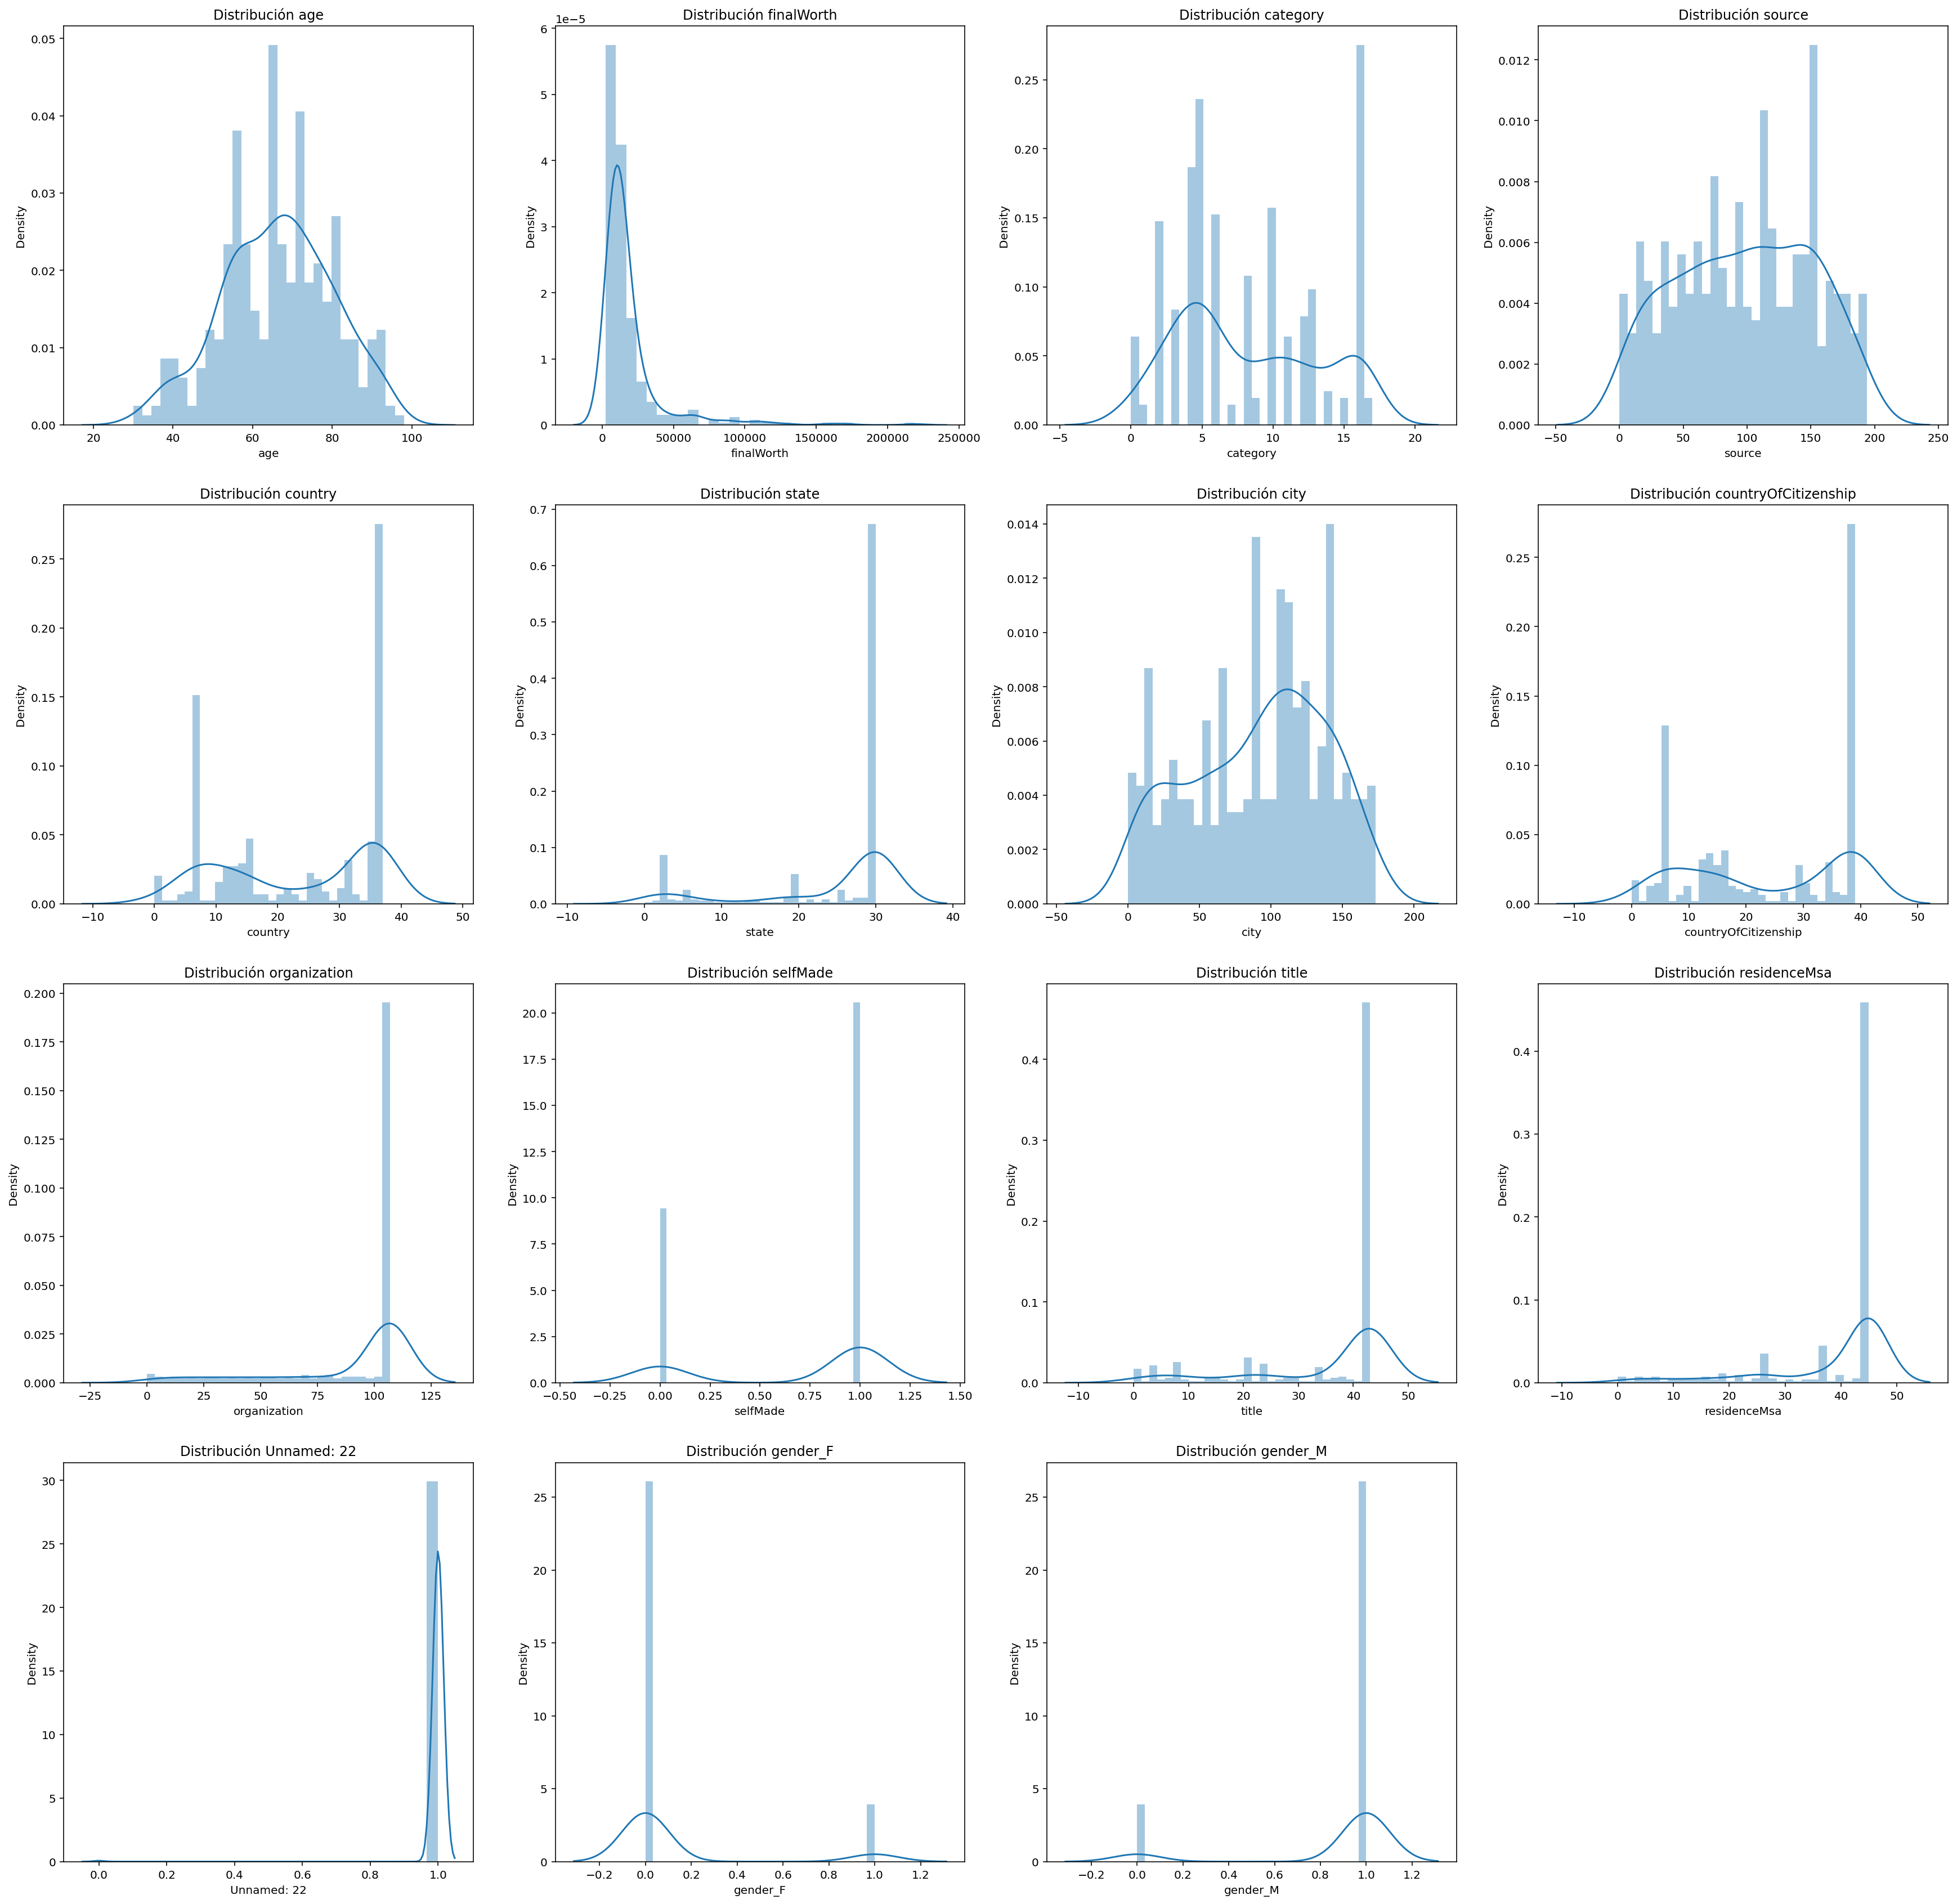

In [ ]:
plt.figure(figsize=(30, 30))
n = 0
for i, column in enumerate(forbes.columns):
    n += 1
    plt.subplot(4, 4, n)
    try:
        sns.distplot(forbes[column], bins=30)
    except:
        pass
    plt.title(f'Distribución {column}')
plt.show()

## 5.- Aplica el test de Shapiro

In [ ]:
# Como todas las columnas son numéricas, no necesitamos filtrar ninguna
for col in forbes.columns:
    stat, p = shapiro(forbes[col])

    print('Valor de test=%.10f, p-value=%.10f' % (stat, p))

    # Una alpha muy pequeña nos muestra que la variable 'age' proviene de una distribución normal (se ve en el histograma como se parece a dicha distribución)
    alpha = 0.00005
    if p > alpha:
        print(f'La variable {col} proviene de una distribución normal (no rechazamos H0) \n')
    else:
        print(f'La variable {col} NO proviene de una distribución normal (rechazamos H0), por lo tanto H1 \n')

Valor de test=0.9911260009, p-value=0.0296579823
La variable age proviene de una distribución normal (no rechazamos H0) 

Valor de test=0.4999439716, p-value=0.0000000000
La variable finalWorth NO proviene de una distribución normal (rechazamos H0), por lo tanto H1 

Valor de test=0.9201605916, p-value=0.0000000000
La variable category NO proviene de una distribución normal (rechazamos H0), por lo tanto H1 

Valor de test=0.9652686715, p-value=0.0000001558
La variable source NO proviene de una distribución normal (rechazamos H0), por lo tanto H1 

Valor de test=0.8229792118, p-value=0.0000000000
La variable country NO proviene de una distribución normal (rechazamos H0), por lo tanto H1 

Valor de test=0.6174182892, p-value=0.0000000000
La variable state NO proviene de una distribución normal (rechazamos H0), por lo tanto H1 

Valor de test=0.9581612349, p-value=0.0000000137
La variable city NO proviene de una distribución normal (rechazamos H0), por lo tanto H1 

Valor de test=0.830688

## 7.- Normaliza los datos numéricos y divídelos en train y test

In [ ]:
# Antes de normalizar, vamos a separar la variable target de las features
# Nuestra variable target va a ser selfMade (si el millonario "se hizo a sí mismo", es decir, empezó de la nada)
features = forbes.drop("selfMade", axis=1)
target = forbes["selfMade"]

In [ ]:
# Normalizamos las features con StandardScaler
scaler = StandardScaler()

features_normalizadas = scaler.fit_transform(features)

In [ ]:
# Dividimos el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(features_normalizadas, target, 
                                                    test_size=0.25,
                                                    random_state=0)

#Importar pickle


In [ ]:
import pickle

## 8.- Aplica el modelo de Regresión Logística, umbraliza los datos y matriz de confusión

In [ ]:
# Instanciamos el modelo y los parámetros que usaremos en el GridSearchCV
modelo_lr = LogisticRegression()
lr_params = {
    "C": [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09], 
    "class_weight": ['balanced', None]
}

In [ ]:
modelo_lr_grid_search = GridSearchCV(estimator=modelo_lr,
                                     param_grid=lr_params,
                                     cv=5,
                                     scoring='roc_auc')

modelo_lr_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,
                               0.09],
                         'class_weight': ['balanced', None]},
             scoring='roc_auc')

In [ ]:
# Instanciamos modelo con la mejor alpha obtenida en el GridSearchCV
reg_log = LogisticRegression(
    C=modelo_lr_grid_search.best_params_['C'],
    class_weight=modelo_lr_grid_search.best_params_['class_weight']
)

# Entrenamos
reg_log.fit(X_train, y_train)

LogisticRegression(C=0.01)

In [ ]:
# Obtenemos las predicciones de y_test
lr_y_test_pred = reg_log.predict_proba(X_test)

# Umbralizamos
lr_umbral_pred = 0.6
lr_y_test_umbralizada = 1 * (lr_y_test_pred[:, 1] > lr_umbral_pred)

In [ ]:
# Obtenemos la matriz de confusión
print(u"Matriz de confusión\n", metrics.confusion_matrix(y_test, lr_y_test_umbralizada))



Matriz de confusión
 [[15 13]
 [ 1 61]]


R2

In [ ]:
lr_y_train_pred = reg_log.predict(X_train)
lr_y_test_pred = reg_log.predict(X_test)
print('La R^2 en los datos de train es: {}'.format(np.round(r2_score(y_train, lr_y_train_pred),2)))
print('La R^2 en los datos de test es: {}'.format(np.round(r2_score(y_test, lr_y_test_pred),2)))

La R^2 en los datos de train es: -0.17
La R^2 en los datos de test es: 0.27


MSE

In [ ]:
print(mean_squared_error(y_test, lr_y_test_pred))

0.15555555555555556


Pickle

In [ ]:
#Crear modelo pickle
pkl_filename = "pickle_model_reg_log.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(reg_log, file)

## 9.- Aplica el modelo de Arboles de Decisión, umbraliza los datos y matriz de confusión

In [ ]:
# Instanciamos modelo de árboles de decisión y parámetros (profundidad del árbol)
modelo_dtr = DecisionTreeRegressor()
dtr_params = { "max_depth": range(3, 7) }

# Sacamos el mejor estimador probando los diferentes parámetros
dtr_optimizado = GridSearchCV(modelo_dtr, dtr_params, cv=3)
dtr_optimizado.fit(X_train, y_train)

print(f"El mejor estimador es: {dtr_optimizado.best_estimator_}")

El mejor estimador es: DecisionTreeRegressor(max_depth=4)


In [ ]:
# Obtenemos predicciones de y_test
dtr_y_test_pred = dtr_optimizado.predict(X_test)

# Umbralizamos
dtr_umbral_pred = 0.6
dtr_y_test_umbralizada = 1 * (dtr_y_test_pred[:] > dtr_umbral_pred)

In [ ]:
# Obtenemos la matriz de confusión
print(u"Matriz de confusión\n", metrics.confusion_matrix(y_test, dtr_y_test_umbralizada))



Matriz de confusión
 [[13 15]
 [ 0 62]]


R2

In [ ]:
dtr_y_train_pred = dtr_optimizado.predict(X_train)
dtr_y_test_pred = dtr_optimizado.predict(X_test)
print('La R^2 en los datos de train es: {}'.format(np.round(r2_score(y_train, dtr_y_train_pred),2)))
print('La R^2 en los datos de test es: {}'.format(np.round(r2_score(y_test, dtr_y_test_pred),2)))

La R^2 en los datos de train es: 0.43
La R^2 en los datos de test es: 0.39


MSE

In [ ]:
print(mean_squared_error(y_test, dtr_y_test_pred))

0.13081089987038358


Pickle

In [ ]:
#Crear modelo pickle
pkl_filename = "pickle_model_dec_tree.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(dtr_optimizado, file)

## 10.- Aplica el modelo de KNN Vecinos , umbraliza los datos y matriz de confusión

In [ ]:
# Instanciamos modelo de KNN vecinos y parámetros (número de vecinos)
modelo_clf = KNeighborsRegressor()
clf_params = { "n_neighbors": range(1, 10) }

# Sacamos el mejor estimador probando los diferentes parámetros
clf_optimizado = GridSearchCV(modelo_clf, clf_params, cv=3)
clf_optimizado.fit(X_train, y_train)

print(f"El mejor estimador es: {clf_optimizado.best_estimator_}")

El mejor estimador es: KNeighborsRegressor(n_neighbors=8)


In [ ]:
# Obtenemos predicciones de y_test
clf_y_test_pred = clf_optimizado.predict(X_test)

# Umbralizamos
clf_umbral_pred = 0.6
clf_y_test_umbralizada = 1 * (clf_y_test_pred[:] > clf_umbral_pred)

In [ ]:
# Obtenemos la matriz de confusión
print(u"Matriz de confusión\n", metrics.confusion_matrix(y_test, clf_y_test_umbralizada))


Matriz de confusión
 [[16 12]
 [ 9 53]]


R2

In [ ]:
clf_y_train_pred = clf_optimizado.predict(X_train)
clf_y_test_pred = clf_optimizado.predict(X_test)
print('La R^2 en los datos de train es: {}'.format(np.round(r2_score(y_train, clf_y_train_pred),2)))
print('La R^2 en los datos de test es: {}'.format(np.round(r2_score(y_test, clf_y_test_pred),2)))

La R^2 en los datos de train es: 0.36
La R^2 en los datos de test es: 0.24


MSE

In [ ]:
print(mean_squared_error(y_test, clf_y_test_pred))

0.1623263888888889


Pickle

In [ ]:
#Crear modelo pickle
pkl_filename = "pickle_model_knn.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf_optimizado, file)

#11.- Aplica el modelo de Random Forest, umbraliza los datos y matriz de confusión

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Defino un modelo
model = RandomForestRegressor()

In [ ]:
# Ajusto el modelo a los datos
model.fit(X_train, y_train)


RandomForestRegressor()

In [ ]:
# Obtenemos predicciones de y_test
y_test_pred = model.predict(X_test)

# Umbralizamos
umbral_pred = 0.6
y_test_umbralizada = 1 * (y_test_pred[:] > umbral_pred)

In [ ]:
# Obtenemos la matriz de confusión
print(u"Matriz de confusión\n", metrics.confusion_matrix(y_test,y_test_umbralizada))


Matriz de confusión
 [[18 10]
 [13 49]]


R2

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('La R^2 en los datos de train es: {}'.format(np.round(r2_score(y_train, y_train_pred),2)))
print('La R^2 en los datos de test es: {}'.format(np.round(r2_score(y_test, y_test_pred),2)))

La R^2 en los datos de train es: 0.91
La R^2 en los datos de test es: 0.35


MSE

In [ ]:
print(mean_squared_error(y_test, y_test_pred))

0.13879555555555556


Pickle

In [ ]:
#Crear modelo pickle
pkl_filename = "pickle_model_r_f.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

#12.- Aplica el modelo de XGBOOST, umbraliza los datos y matriz de confusión

In [ ]:
import xgboost as xgb 

In [ ]:
# Obtengo el mejor parámetro de profundidad del árbol entre 3 y 7 usando 
# validación cruzada y gridsearch
regr = xgb.XGBRegressor()
params = {"eta": [0.3, 0.5], "lambda":[0.5, 1.0], "max_depth": [3, 7]}
regr_opt = GridSearchCV(regr, params, cv=3)
regr_opt.fit(X_train, y_train)

[17:09:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=3, estimator=XGBRegressor(),
             param_grid={'eta': [0.3, 0.5], 'lambda': [0.5, 1.0],
                         'max_depth': [3, 7]})

In [ ]:
# Obtenemos predicciones de y_test
y_test_pred1 = regr_opt.predict(X_test)

# Umbralizamos
umbral_pred = 0.6
y_test_umbralizada1 = 1 * (y_test_pred1[:] > umbral_pred)

In [ ]:
# Obtenemos la matriz de confusión
print(u"Matriz de confusión\n", metrics.confusion_matrix(y_test,y_test_umbralizada1))

Matriz de confusión
 [[18 10]
 [12 50]]


R2

In [ ]:
y_train_pred1 = regr_opt.predict(X_train)
y_test_pred1 = regr_opt.predict(X_test)
print('La R^2 en los datos de train es: {}'.format(np.round(r2_score(y_train, y_train_pred1),2)))
print('La R^2 en los datos de test es: {}'.format(np.round(r2_score(y_test, y_test_pred1),2)))

La R^2 en los datos de train es: 0.81
La R^2 en los datos de test es: 0.31


MSE

In [ ]:
print(mean_squared_error(y_test, y_test_pred1))

0.14789022035394478


Pickle

In [ ]:
#Crear modelo pickle
pkl_filename = "pickle_model_xgb.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(regr_opt, file)

#13.- Aplica el modelo de SVM kernel RBF , umbraliza los datos y matriz de confusión

In [ ]:
from sklearn.svm import SVR

In [ ]:
# Ajuste del modelo de regresión
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

In [ ]:
svr_rbf = SVR(verbose=True)

svr_rbf.fit(X_train, y_train)

[LibSVM]

SVR(verbose=True)

In [ ]:
# Obtenemos las predicciones de y_test
y_pred = svr_rbf.predict(X_test)

In [ ]:
# Umbralizamos
umbral = 0.6
svr_y_test_umbralizada = 1 * (y_pred[:, ] > umbral)

In [ ]:
# Obtenemos la matriz de confusión
print(u"Matriz de confusión\n", metrics.confusion_matrix(y_test,svr_y_test_umbralizada))

Matriz de confusión
 [[17 11]
 [ 7 55]]


R2

In [ ]:
svr_y_train_pred = svr_rbf.predict(X_train)
svr_y_test_pred = svr_rbf.predict(X_test)
print('La R^2 en los datos de train es: {}'.format(np.round(r2_score(y_train, svr_y_train_pred),2)))
print('La R^2 en los datos de test es: {}'.format(np.round(r2_score(y_test, svr_y_test_pred),2)))

La R^2 en los datos de train es: 0.51
La R^2 en los datos de test es: 0.3


MSE

In [ ]:
print(mean_squared_error(y_test, svr_y_test_pred))

0.14962864261723371


Pickle

In [ ]:
#Crear modelo pickle
pkl_filename = "pickle_model_svr_rbf.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svr_rbf, file)

#14.- Aplica el modelo de SVM kernel linear , umbraliza los datos y matriz de confusión

In [ ]:
svr_lin = SVR(kernel='linear', C=100, gamma='auto')

In [ ]:
svr_lin.fit(X_train, y_train)

y_pred_lin = svr_lin.predict(X_test)

In [ ]:
# Umbralizamos
umbral = 0.6
svr_lin_y_test_umbralizada = 1 * (y_pred_lin[:, ] > umbral)

In [ ]:
# Obtenemos la matriz de confusión
print(u"Matriz de confusión\n", metrics.confusion_matrix(y_test,svr_lin_y_test_umbralizada))

Matriz de confusión
 [[14 14]
 [ 0 62]]


R2

In [ ]:
svr_lin_train_pred = svr_lin.predict(X_train)
svr_lin_test_pred = svr_lin.predict(X_test)
print('La R^2 en los datos de train es: {}'.format(np.round(r2_score(y_train, svr_lin_train_pred),2)))
print('La R^2 en los datos de test es: {}'.format(np.round(r2_score(y_test, svr_lin_test_pred),2)))

La R^2 en los datos de train es: 0.03
La R^2 en los datos de test es: 0.37


MSE

In [ ]:
print(mean_squared_error(y_test, svr_lin_test_pred))

0.134465779744339


Pickle

In [ ]:
#Crear modelo pickle
pkl_filename = "pickle_model_svr_lin.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svr_lin, file)

#15.- Aplica el modelo de SVM kernel polinomico , umbraliza los datos y matriz de confusión

In [ ]:
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

In [ ]:
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1, verbose = True)

svr_poly.fit(X_train, y_train)

y_pred_ply = svr_poly.predict(X_test)

[LibSVM]

In [ ]:
# Umbralizamos
umbral = 0.6
svr_ply_y_test_umbralizada = 1 * (y_pred_ply[:, ] > umbral)

In [ ]:
# Obtenemos la matriz de confusión
print(u"Matriz de confusión\n", metrics.confusion_matrix(y_test,svr_ply_y_test_umbralizada))

Matriz de confusión
 [[16 12]
 [22 40]]


R2

In [ ]:
svr_poly_y_train_pred = svr_poly.predict(X_train)
svr_poly_y_test_pred = svr_poly.predict(X_test)
print('La R^2 en los datos de train es: {}'.format(np.round(r2_score(y_train, svr_poly_y_train_pred),2)))
print('La R^2 en los datos de test es: {}'.format(np.round(r2_score(y_test, svr_poly_y_test_pred),2)))

La R^2 en los datos de train es: 0.79
La R^2 en los datos de test es: -5.63


MSE

In [ ]:
print(mean_squared_error(y_test, svr_poly_y_test_pred))

1.421727752012451


Pickle

In [ ]:
#Crear modelo pickle
pkl_filename = "pickle_model_svr_poly.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svr_poly, file)